In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns
sns.set(style='whitegrid')

### Load and look at data

In [2]:
#Load dataframe and drop duplicate interactions based on standardized characteristics
df = pd.read_csv('C:/Users/Elin/Documents/GitHub/predicting-allostery/datafiles/features/features_interactions_merged_types.txt', header=0, index_col=0)
df.drop_duplicates(['EC', 'Org', 'Mode', 'ChEBI', 'Interpro_ids'], inplace=True)

#### Most frequent features

In [3]:
#Count the frequency of the features
top_features = df[['Interpro_ids', 'ENTRY_TYPE', 'ENTRY_NAME']].value_counts().to_frame().reset_index()
top_features.columns = ['Domain', 'Entry type', 'Entry name', 'Count']

In [4]:
#Look at the top 10 features
top_features.head(10)

,Domain,Entry type,Entry name,Count
0,IPR036291,Homologous_superfamily,NAD(P)-binding domain superfamily,1187
1,IPR027417,Homologous_superfamily,P-loop containing nucleoside triphosphate hydr...,822
2,IPR013785,Homologous_superfamily,Aldolase-type TIM barrel,567
3,IPR029044,Homologous_superfamily,Nucleotide-diphospho-sugar transferases,426
4,IPR015421,Homologous_superfamily,"Pyridoxal phosphate-dependent transferase, maj...",421
5,IPR015424,Homologous_superfamily,Pyridoxal phosphate-dependent transferase,420
6,IPR015422,Homologous_superfamily,"Pyridoxal phosphate-dependent transferase, sma...",377
7,IPR036188,Homologous_superfamily,FAD/NAD(P)-binding domain superfamily,293
8,IPR011009,Homologous_superfamily,Protein kinase-like domain superfamily,281
9,IPR011004,Homologous_superfamily,Trimeric LpxA-like superfamily,270


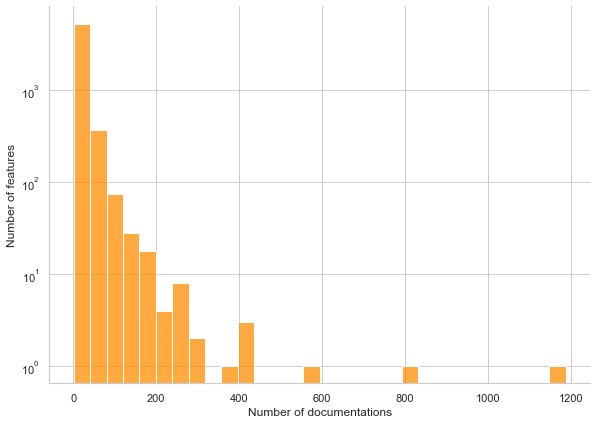

In [5]:
#Plot frequency histogram of features
ax = sns.displot(data=top_features, x='Count', kind='hist', height=6, aspect=1.4, bins=30, log_scale=[False, True], color='darkorange')
ax.set_xlabels('Number of documentations')
ax.set_ylabels('Number of features')

### Fisher's exact test

#### Prepare and perform Fisher's exact test

In [10]:
#Make dictionary of ChEBI ids and synonyms for all metabolites
#Example: CHEBI:15422: {ATP, adenosine triphosphate}
df_mets_grouped = df[['Met', 'ChEBI']].drop_duplicates().groupby(['ChEBI'])['Met'].apply(set).reset_index()
mets_dict = pd.Series(df_mets_grouped.Met.values, index=df_mets_grouped.ChEBI).to_dict()

In [7]:
#Make columns with enzyme info (EC number + organism) and interaction info (ChEBI id + mode) for Fisher's exact test
df['enzyme'] = df['EC'] + ':' + df['Org']
df['interaction'] = df['ChEBI'] + ':' + df['Mode']

In [8]:
#Make dataframe of all enzymes (EC+org) for which a feature (InterPro id) is documented
features = df.groupby('Interpro_ids').agg({'enzyme': set})

#Make dataframe of all enzymes (EC+org) for which an interaction (ChEBI+mode) is documented
interactions = df.groupby('interaction').agg({'enzyme': set})

#Make dataframe of all possible interaction-feature pairs, and sort by number of enzymes (EC+org) for which they are documented
pairs = df.groupby(['interaction', 'Interpro_ids']).agg({'enzyme': len}).sort_values('enzyme', ascending=False)

#Make a set of all enzymes (EC+org)
all_enzymes = set(df['enzyme'])

In [9]:
#Define function for performing one-sided Fisher's exact test
def calculate_fisher_one_sided(f, i):
    with_f = features.loc[f, 'enzyme']
    without_f = all_enzymes - with_f
    with_i = interactions.loc[i, 'enzyme']
    without_i = all_enzymes - with_i

    yy = len(with_f & with_i)
    yn = len(with_f & without_i)
    ny = len(without_f & with_i)
    nn = len(without_f & without_i)

    return fisher_exact([[yy, yn], [ny, nn]], alternative='greater')

In [10]:
#Perform Fisher's exact test on all interaction-feature pairs

data = []

for (i, f) in pairs.index:
    odds, p = calculate_fisher_one_sided(f, i)
    data.append([i, f, odds, p])

df_one_sided = pd.DataFrame(data, columns=['interaction', 'features', 'odds', 'p'])

#### Adjust p-value and odds ratio

In [11]:
#Do fdr correction on p-values to get adjusted p-value (q-value)
df_one_sided['is_significant'], df_one_sided['q'] = fdrcorrection(df_one_sided['p'])

In [12]:
#As the odds ratio for some associations is inifinity, this need to be adjusted for
#This codeline checks if there are any odds higher than 15 000
df_one_sided.query('odds > 15000').sort_values('odds')

,interaction,features,odds,p,is_significant,q
90,CHEBI:14336:-,IPR005999,inf,1.997106e-29,True,1.051349e-25
38854,CHEBI:16238:+,IPR009158,inf,3.109269e-03,True,1.357752e-02
38845,CHEBI:16243:-,IPR035579,inf,2.665087e-02,True,4.849938e-02
38844,CHEBI:16243:-,IPR035574,inf,2.665087e-02,True,4.849938e-02
38843,CHEBI:16243:-,IPR035572,inf,2.665087e-02,True,4.849938e-02
...,...,...,...,...,...,...
21908,CHEBI:57844:-,IPR045785,inf,1.465798e-02,True,3.362091e-02
21907,CHEBI:57844:-,IPR044639,inf,1.465798e-02,True,3.362091e-02
21902,CHEBI:57844:-,IPR042118,inf,1.465798e-02,True,3.362091e-02
21810,CHEBI:57856:-,IPR010049,inf,1.880367e-02,True,3.884533e-02


In [13]:
#Change all odds that are infinity to 15 000
df_one_sided['odds'] = df_one_sided['odds'].apply(lambda x: min(x, 15000))

In [14]:
#Make columns with log10(odds ratio) and -log10(adj. p-value) 
df_one_sided['log_o'] = np.log10(df_one_sided['odds'])
df_one_sided['log_q'] = -np.log10(df_one_sided['q'])

In [25]:
#Save all results to file
df_one_sided.to_csv('C:/Users/Elin/Documents/GitHub/predicting-allostery/datafiles/results/fishers_test_results.txt')

#### Make volcano plot

c:\Users\Elin\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='log_o', ylabel='log_q'>

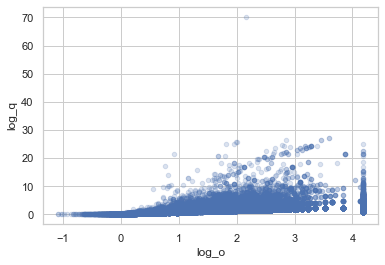

In [21]:
df_one_sided.plot.scatter('log_o', 'log_q', alpha=0.2)

### Filter for predicted interactions

In [22]:
#Make dataframe of interactions and features that are associated with q < 0.05 and log10(odds ratio) >= 1
df_predicted = df_one_sided[(df_one_sided['q'] < 0.05) & (df_one_sided['log_o'] >= 1)].drop_duplicates()

In [38]:
#Save the predicted interactions to file
df_predicted.to_csv('C:/Users/Elin/Documents/GitHub/predicting-allostery/datafiles/results/predicted_interactions.txt')

### Classify features by name and type

In [6]:
#Get list of entry type and name for InterPro ids, downloaded from the InterPro website
df_entry_list = pd.read_csv('C:/Users/Elin/Documents/GitHub/predicting-allostery/datafiles/support/entry.list.txt', sep='\t', header=0)

In [7]:
#Merge dataframe of associated features and interactions with the entry-list
df_merged = pd.merge(df_one_sided, df_entry_list, left_on='features', right_on='ENTRY_AC', how='left').drop('ENTRY_AC', axis=1)

In [11]:
#Add columns for mode, ChEBI id and metabolite name 
df_merged['mode'] = df_merged['interaction'].apply(lambda x: x[-1])

df_merged['ChEBI'] = df_merged['interaction'].apply(lambda x: x[:-2])

df_merged['Met'] = df_merged['ChEBI'].map(mets_dict)

#### Analyse all feature types

In [12]:
sns.set(style='white')

In [13]:
#List of all eight feature types in the data
feature_types = ['Active_site', 'Binding_site', 'Conserved_site', 'Domain', 'Family', 'Homologous_superfamily', 'PTM', 'Repeat']

In [14]:
#Make dataframes of interaction-feature associations grouped by feature type
dfs = {type:df_merged.query('ENTRY_TYPE == @type') for type in feature_types}

In [15]:
#Make dataframes of activating interaction-feature associations grouped by feature type
dfs_acts = {type:df_merged.query('ENTRY_TYPE == @type & mode == "+"') for type in feature_types}

In [16]:
#Make dataframes of inhibiting interaction-feature associations grouped by feature type
dfs_inhs = {type:df_merged.query('ENTRY_TYPE == @type & mode == "-"') for type in feature_types}

###### Make functions for plotting histograms of number of interactions/features associated with each feature/interaction

In [137]:
def plot_histogram_features(type, aspect, mode=None, count_limit=0):
    #Specify which group of interactions should be plotted (activators, inhibitors, all)
    df = pd.DataFrame
    if mode == '+':
        df = dfs_acts
    elif mode == '-':
        df = dfs_inhs
    else:
        df = dfs

    #Find statistically significant assocations
    df_significant = df[type].query('q < 0.05 & log_o >= 1')
    #Make column with interaction given by metabolite name (for easier interpretation)
    df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']

    #Make dataframe of features and their associated interactions, and sort by number of associated interactions

    df_significant_groups = df_significant.groupby(['features'])['interaction'].apply(list).reset_index()

    df_significant_groups['Count'] = df_significant_groups['interaction'].agg(len)
    df_significant_groups = df_significant_groups.sort_values('Count', ascending=False)

    #Plot histogram of number of interactions associated with each feature
    h = sns.catplot(data=df_significant_groups[df_significant_groups['Count'] >= count_limit], x='features', y='Count', kind='bar', aspect=aspect, palette='crest')
    h.set_xticklabels(rotation=90)
    h.set_xlabels(f'{type.replace("_", " ")} (InterPro id)')
    h.set_ylabels('Number of interactions')
    plt.text(0.85, 0.85, f'Mode: {mode}\nCount limit: {count_limit} ', fontsize=15, transform=plt.gca().transAxes)


In [82]:
def plot_histogram_interactions(type, aspect, mode=None, count_limit=0):
    #Specify which group of interactions should be plotted (activators, inhibitors, all)
    df = pd.DataFrame
    if mode == '+':
        df = dfs_acts
    elif mode == '-':
        df = dfs_inhs
    else:
        df = dfs
        
    #Find statistically significant assocations
    df_significant = df[type].query('q < 0.05 & log_o >= 1')
    #Make column with interaction given by metabolite name (for easier interpretation)
    df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']

    #Make dataframe of features and their associated interactions, and sort by number of associated interactions

    df_significant_groups = df_significant.groupby(['interaction(met)'])['features'].apply(list).reset_index()

    df_significant_groups['Count'] = df_significant_groups['features'].agg(len)
    df_significant_groups = df_significant_groups.sort_values('Count', ascending=False)

    #Plot histogram of number of interactions associated with each feature
    h = sns.catplot(data=df_significant_groups[df_significant_groups['Count'] >= count_limit], x='interaction(met)', y='Count', kind='bar', aspect=aspect, palette='flare')
    h.set_xticklabels(rotation=90)
    h.set_xlabels('Interaction')
    h.set_ylabels(f'Number of {type.replace("_", " ").lower()}s')
    plt.text(0.85, 0.85, f'Mode: {mode}\nCount limit: {count_limit} ', fontsize=15, transform=plt.gca().transAxes)
   


##### Active sites

In [31]:
dfs['Active_site'].sort_values(['log_q', 'log_o'], ascending=False).head(20)

,interaction,features,odds,p,is_significant,q,log_o,log_q,ENTRY_TYPE,ENTRY_NAME,mode,ChEBI,Met
22,CHEBI:17489:+,IPR008271,102.446154,1.770729e-30,True,1.464848e-26,2.010496,25.834207,Active_site,"Serine/threonine-protein kinase, active site",+,CHEBI:17489,"{3'-5'-AMP, cyclic-3',5'-AMP, c-3',5'-AMP, ade..."
375,CHEBI:16710:-,IPR020878,7581.375000,4.900432e-25,True,4.577003e-22,3.879748,21.339419,Active_site,"Ribulose bisphosphate carboxylase, large chain...",-,CHEBI:16710,"{Ribulose 1,5-diphosphate, Ribulose 1,5-bispho..."
129,CHEBI:28013:+,IPR018209,174.283702,4.687837e-21,True,2.798590e-18,2.241257,17.553061,Active_site,"Pyruvate kinase, active site",+,CHEBI:28013,"{D-fructose 1,6 bisphosphate, D-fructose-1,6-d..."
308,CHEBI:28013:-,IPR020548,154.720930,5.909988e-16,True,1.702665e-13,2.189549,12.768871,Active_site,"Fructose-1,6-bisphosphatase, active site",-,CHEBI:28013,"{D-fructose 1,6 bisphosphate, D-fructose-1,6-d..."
291,CHEBI:16474:-,IPR019796,414.088050,7.948119e-16,True,2.202199e-13,2.617093,12.657143,Active_site,"Glucose-6-phosphate dehydrogenase, active site",-,CHEBI:16474,"{NADPH, NAD(P)H, beta-NADPH}"
382,CHEBI:30744:-,IPR001252,273.880734,5.957227e-15,True,1.461742e-12,2.437561,11.835129,Active_site,"Malate dehydrogenase, active site",-,CHEBI:30744,"{oxalacetate, oxaloacetate, 2-oxosuccinate, ox..."
338,CHEBI:28013:+,IPR018177,159.960000,8.743009e-15,True,2.109542e-12,2.204011,11.675812,Active_site,"L-lactate dehydrogenase, active site",+,CHEBI:28013,"{D-fructose 1,6 bisphosphate, D-fructose-1,6-d..."
840,CHEBI:16284:+,IPR030475,1261.875000,1.581744e-14,True,3.521378e-12,3.101016,11.453287,Active_site,"Ribonucleotide reductase small subunit, acitve...",+,CHEBI:16284,"{5'-dATP, deoxyATP, dATP, 2'-deoxy-ATP, 2'-deo..."
1046,CHEBI:16497:+,IPR030475,1261.875000,1.581744e-14,True,3.521378e-12,3.101016,11.453287,Active_site,"Ribonucleotide reductase small subunit, acitve...",+,CHEBI:16497,"{deoxyGTP, 2'-deoxy-GTP, dGTP}"
1144,CHEBI:16311:+,IPR030475,1261.875000,1.581744e-14,True,3.521378e-12,3.101016,11.453287,Active_site,"Ribonucleotide reductase small subunit, acitve...",+,CHEBI:16311,{dCTP}


C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


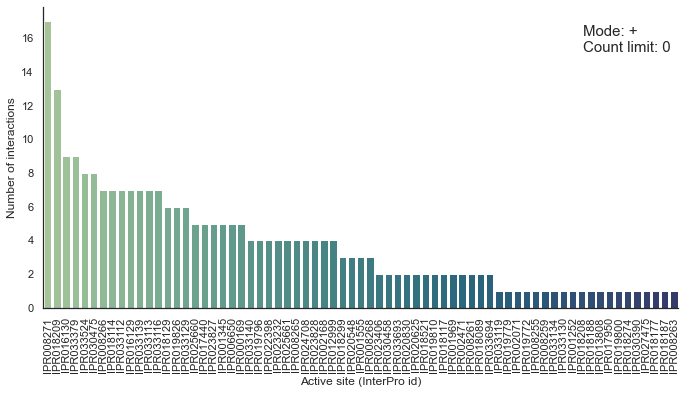

In [138]:
#Plot histogram of number of interactions associated with each active site for activators
plot_histogram_features(type='Active_site', mode = '+', aspect=2)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


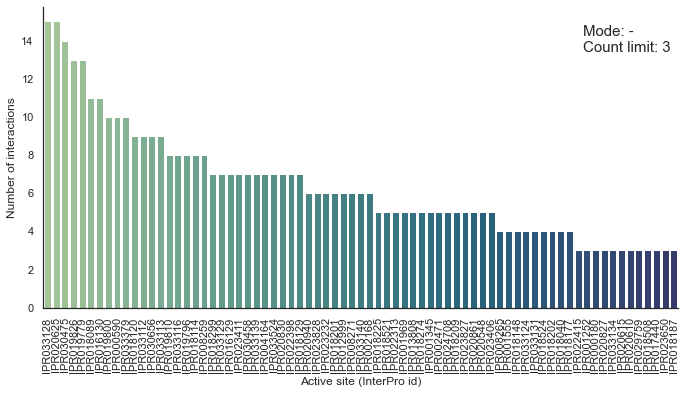

In [85]:
#Plot histogram of number of interactions associated with each active site for inhibitors
plot_histogram_features(type='Active_site', mode = '-', aspect=2, count_limit=3)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


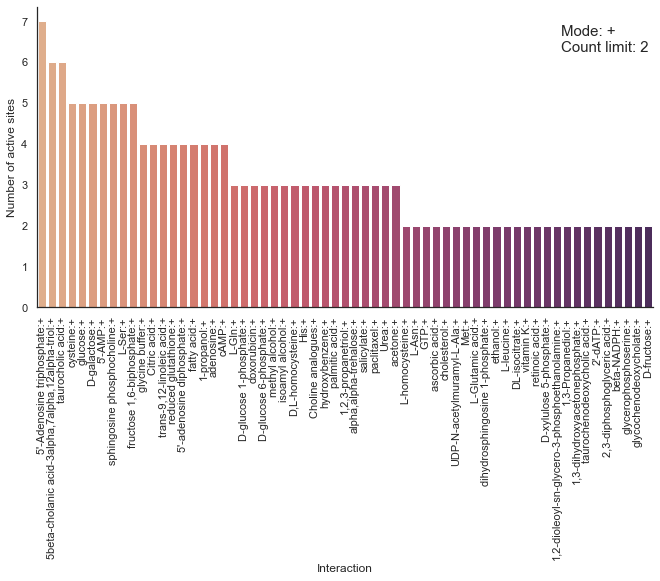

In [93]:
#Plot histogram of number of active sites associated with each interaction for activators
plot_histogram_interactions(type='Active_site', aspect=2.2, mode='+', count_limit=2)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


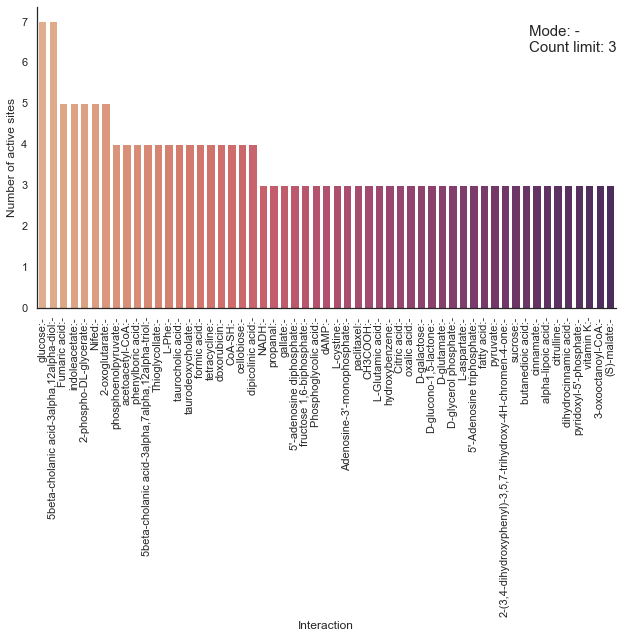

In [98]:
#Plot histogram of number of active sites associated with each interaction for inhibitors
plot_histogram_interactions(type='Active_site', aspect=2, mode='-', count_limit=3)

#### Binding sites

In [36]:
#Look at the most highly associated interactions and binding sites
dfs['Binding_site'].sort_values(['log_q', 'log_o'], ascending=False).head(20)

,interaction,features,odds,p,is_significant,q,log_o,log_q,ENTRY_TYPE,ENTRY_NAME,mode,ChEBI,Met
20,CHEBI:17489:+,IPR017441,99.585470,2.788081e-30,True,2.018152e-26,1.998196,25.695046,Binding_site,"Protein kinase, ATP binding site",+,CHEBI:17489,"{3'-5'-AMP, cyclic-3',5'-AMP, c-3',5'-AMP, ade..."
568,CHEBI:15956:+,IPR001882,1122.333333,4.619034e-17,True,1.582716e-14,3.050122,13.800597,Binding_site,Biotin-binding site,+,CHEBI:15956,{biotin}
396,CHEBI:16474:-,IPR006184,15000.000000,1.304258e-13,True,2.468202e-11,4.176091,10.607619,Binding_site,6-phosphogluconate-binding site,-,CHEBI:16474,"{NADPH, NAD(P)H, beta-NADPH}"
528,CHEBI:58095:-,IPR018301,173.116883,2.138402e-13,True,3.833764e-11,2.238339,10.416375,Binding_site,"Aromatic amino acid hydroxylase, iron/copper b...",-,CHEBI:58095,"{Phe, L-phenylalanine, L-Phe, phenylalanine}"
1070,CHEBI:18243:-,IPR018301,279.916667,4.095130e-12,True,5.365176e-10,2.447029,9.270416,Binding_site,"Aromatic amino acid hydroxylase, iron/copper b...",-,CHEBI:18243,"{3-Hydroxytyramine, L-1-(3,4-dihydroxyphenyl)-..."
634,CHEBI:26355:-,IPR001917,120.220513,7.802906e-12,True,9.573108e-10,2.079979,9.018947,Binding_site,"Aminotransferase, class-II, pyridoxal-phosphat...",-,CHEBI:26355,"{Haemin, Fe-protoporphyrin complex, heme, hemin}"
2477,CHEBI:16176:-,IPR022653,4495.333333,1.211248e-11,True,1.405631e-09,3.652762,8.852129,Binding_site,"Orn/DAP/Arg decarboxylase 2, pyridoxal-phospha...",-,CHEBI:16176,"{D-ornithine, D-Orn}"
812,CHEBI:4170:-,IPR019807,188.000000,1.473424e-10,True,1.316713e-08,2.274158,7.880509,Binding_site,"Hexokinase, binding site",-,CHEBI:4170,"{glucose-6-phosphate, glucose 6-phosphate, D-g..."
628,CHEBI:16356:+,IPR017441,71.981538,1.485152e-10,True,1.325149e-08,1.857221,7.877735,Binding_site,"Protein kinase, ATP binding site",+,CHEBI:16356,"{3',5'-cyclic GMP, 3',5'-cGMP, guanosine cycli..."
741,CHEBI:17345:-,IPR018220,76.606612,5.454973e-10,True,4.167369e-08,1.884266,7.380138,Binding_site,"Adenylosuccinate synthase, GTP-binding site",-,CHEBI:17345,"{GMP, guanine ribose 5'-phosphate, 5'-GMP, acy..."


C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


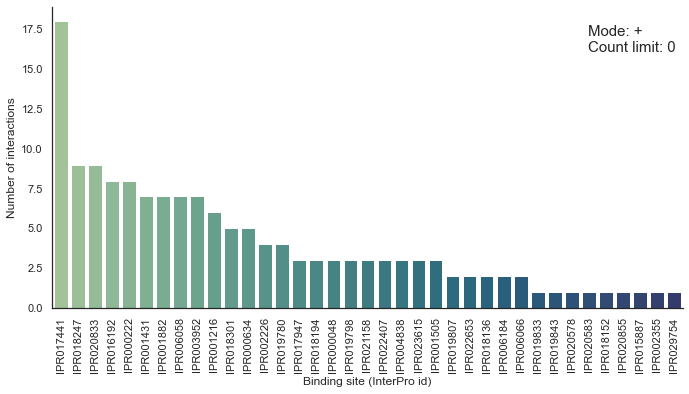

In [99]:
#Plot histogram of number of interactions associated with each binding site for activators
plot_histogram_features(type='Binding_site', aspect=2, mode= '+')

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


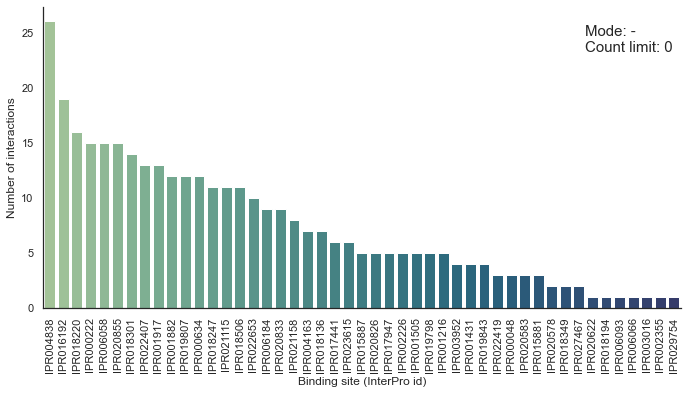

In [102]:
#Plot histogram of number of interactions associated with each binding site for inhibitors
plot_histogram_features(type='Binding_site', aspect=2, mode= '-')

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


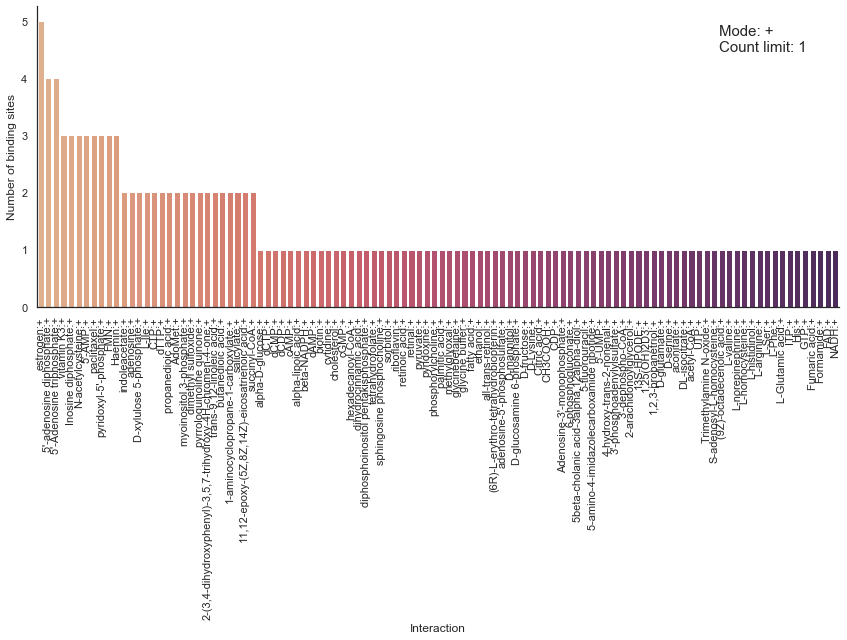

In [108]:
#Plot histogram of number of binding sites associated with each interaction for activators
plot_histogram_interactions(type='Binding_site', aspect=2.5, mode='+', count_limit=1)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


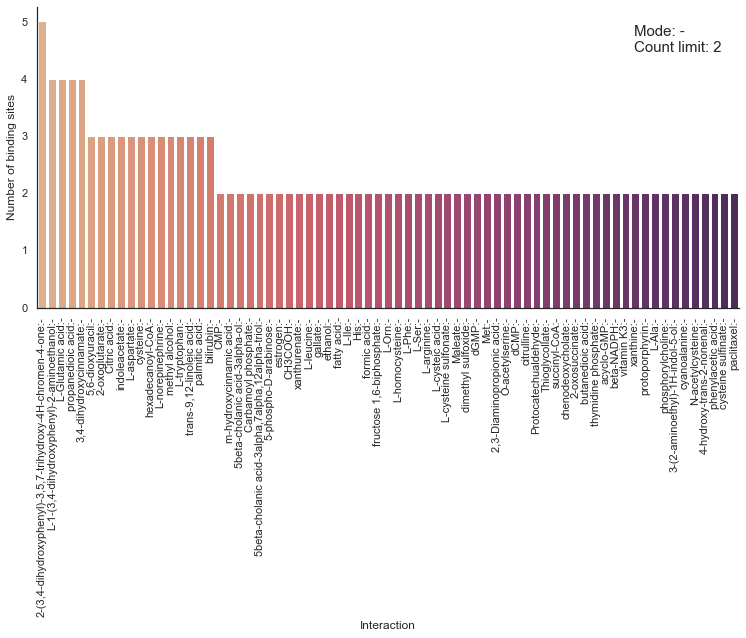

In [105]:
#Plot histogram of number of binding sites associated with each interaction for inhibitors
plot_histogram_interactions(type='Binding_site', aspect=2.5, mode='-', count_limit=2)

#### Conserved sites

In [40]:
#Look at the most highly associated interactions and binding sites
dfs['Conserved_site'].sort_values(['log_q', 'log_o'], ascending=False).head(10)

,interaction,features,odds,p,is_significant,q,log_o,log_q,ENTRY_TYPE,ENTRY_NAME,mode,ChEBI,Met
54,CHEBI:17794:+,IPR005836,3917.083333,3.107856e-32,True,5.998991e-28,3.592963,27.221922,Conserved_site,"ADP-glucose pyrophosphorylase, conserved site",+,CHEBI:17794,"{D-3-phosphoglycerate, 3-phospho-D-glycerate, ..."
89,CHEBI:17969:+,IPR005836,2913.733333,4.052833e-31,True,3.911524e-27,3.464450,26.407654,Conserved_site,"ADP-glucose pyrophosphorylase, conserved site",+,CHEBI:17969,"{sedoheptulose 1,7-diphosphate, sedoheptulose ..."
62,CHEBI:28898:-,IPR033690,614.352941,4.560998e-29,True,2.200986e-25,2.788418,24.657383,Conserved_site,"Adenylate kinase, conserved site",-,CHEBI:28898,"{P1,P5-di(adenosine-5')pentaphosphate, P1,P5-d..."
153,CHEBI:15925:+,IPR005836,1921.428571,2.345501e-28,True,7.148594e-25,3.283624,24.145779,Conserved_site,"ADP-glucose pyrophosphorylase, conserved site",+,CHEBI:15925,{2-keto-3-deoxy phosphogluconate}
169,CHEBI:30841:+,IPR005836,1921.428571,2.345501e-28,True,7.148594e-25,3.283624,24.145779,Conserved_site,"ADP-glucose pyrophosphorylase, conserved site",+,CHEBI:30841,"{3-hydroxypyruvate, beta-Hydroxypyruvate, 3-hy..."
183,CHEBI:55513:+,IPR005836,1921.428571,2.345501e-28,True,7.148594e-25,3.283624,24.145779,Conserved_site,"ADP-glucose pyrophosphorylase, conserved site",+,CHEBI:55513,"{2-deoxy-D-ribose 5-phosphate, D-deoxyribose 5..."
104,CHEBI:14336:-,IPR018483,2490.428571,2.782468e-28,True,7.323962e-25,3.396274,24.135254,Conserved_site,"Carbohydrate kinase, FGGY, conserved site",-,CHEBI:14336,"{glycerophosphate, alpha-glycerophosphate, gly..."
118,CHEBI:44897:+,IPR005836,1503.965517,2.751545e-28,True,7.323962e-25,3.177238,24.135254,Conserved_site,"ADP-glucose pyrophosphorylase, conserved site",+,CHEBI:44897,"{phosphoenolpyruvate, phospho-enol-pyruvate}"
149,CHEBI:30831:+,IPR005836,1793.066667,4.220165e-28,True,9.775252e-25,3.253596,24.009872,Conserved_site,"ADP-glucose pyrophosphorylase, conserved site",+,CHEBI:30831,"{alpha-Ketobutyrate, 2-oxo-butanoic acid, 2-ox..."
152,CHEBI:18283:-,IPR005836,1581.647059,1.258806e-27,True,2.429832e-24,3.199110,23.614424,Conserved_site,"ADP-glucose pyrophosphorylase, conserved site",-,CHEBI:18283,"{trehalose phosphate, trehalose 6-phosphate}"


C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


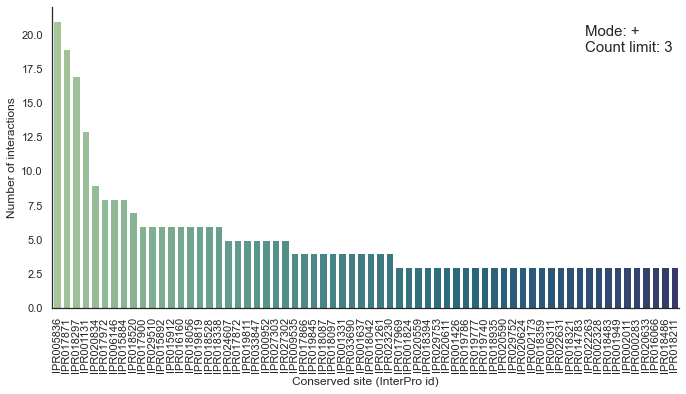

In [114]:
#Plot histogram of number of interactions associated with each conserved site for activators
plot_histogram_features(type='Conserved_site', aspect=2, mode='+', count_limit=3)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


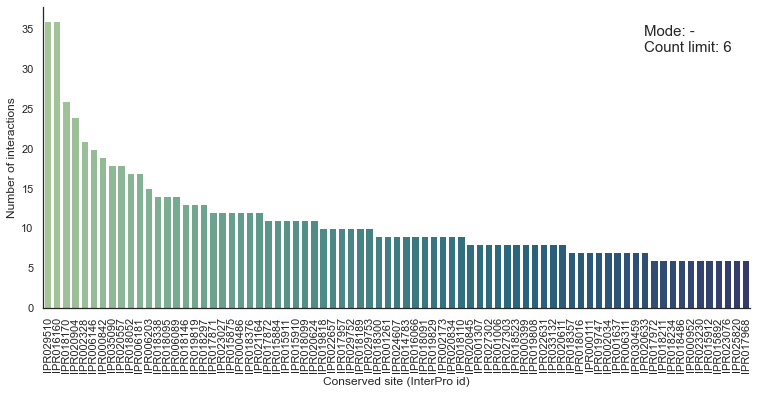

In [119]:
#Plot histogram of number of interactions associated with each conserved site for inhibitors
plot_histogram_features(type='Conserved_site', aspect=2.2, mode='-', count_limit=6)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


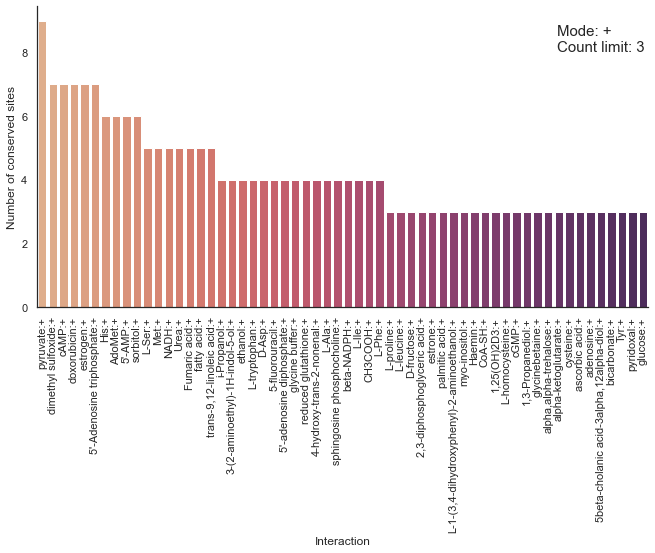

In [124]:
#Plot histogram of number of conserved sites associated with each interaction for activators
plot_histogram_interactions(type='Conserved_site', aspect=2, mode = '+', count_limit=3)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


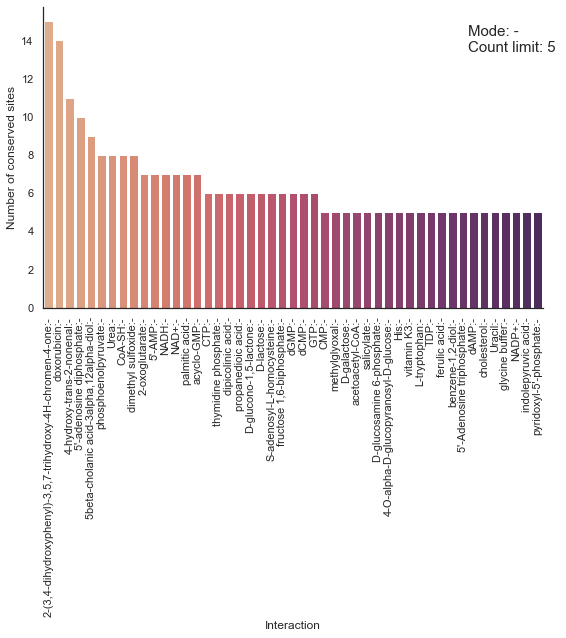

In [129]:
#Plot histogram of number of conserved sites associated with each interaction for inhibitors
plot_histogram_interactions(type='Conserved_site', aspect=2, mode = '-', count_limit=5)

#### Domains

In [45]:
#Look at the most highly associated interactions and domains
dfs['Domain'].sort_values(['log_q', 'log_o'], ascending=False).head(10)

,interaction,features,odds,p,is_significant,q,log_o,log_q,ENTRY_TYPE,ENTRY_NAME,mode,ChEBI,Met
23,CHEBI:17489:+,IPR000719,89.573077,1.556960e-29,True,9.016044e-26,1.952177,25.044984,Domain,Protein kinase domain,+,CHEBI:17489,"{3'-5'-AMP, cyclic-3',5'-AMP, c-3',5'-AMP, ade..."
58,CHEBI:17794:+,IPR005835,652.361111,7.898087e-29,True,3.518172e-25,2.814488,24.453683,Domain,Nucleotidyl transferase domain,+,CHEBI:17794,"{D-3-phosphoglycerate, 3-phospho-D-glycerate, ..."
80,CHEBI:17969:+,IPR005835,831.876190,2.961348e-28,True,7.455902e-25,2.920059,24.127500,Domain,Nucleotidyl transferase domain,+,CHEBI:17969,"{sedoheptulose 1,7-diphosphate, sedoheptulose ..."
105,CHEBI:14336:-,IPR018484,1245.028571,2.076789e-27,True,3.758209e-24,3.095179,23.425019,Domain,"Carbohydrate kinase, FGGY, N-terminal",-,CHEBI:14336,"{glycerophosphate, alpha-glycerophosphate, gly..."
107,CHEBI:14336:-,IPR018485,1245.028571,2.076789e-27,True,3.758209e-24,3.095179,23.425019,Domain,"Carbohydrate kinase, FGGY, C-terminal",-,CHEBI:14336,"{glycerophosphate, alpha-glycerophosphate, gly..."
176,CHEBI:57926:-,IPR001341,15000.000000,1.841423e-26,True,2.806134e-23,4.176091,22.551892,Domain,Aspartate kinase,-,CHEBI:57926,"{L-threonine, threonine, L-Thr, Thr}"
150,CHEBI:15925:+,IPR005835,720.000000,6.431651e-26,True,8.661489e-23,2.857332,22.062407,Domain,Nucleotidyl transferase domain,+,CHEBI:15925,{2-keto-3-deoxy phosphogluconate}
164,CHEBI:30841:+,IPR005835,720.000000,6.431651e-26,True,8.661489e-23,2.857332,22.062407,Domain,Nucleotidyl transferase domain,+,CHEBI:30841,"{3-hydroxypyruvate, beta-Hydroxypyruvate, 3-hy..."
198,CHEBI:55513:+,IPR005835,720.000000,6.431651e-26,True,8.661489e-23,2.857332,22.062407,Domain,Nucleotidyl transferase domain,+,CHEBI:55513,"{2-deoxy-D-ribose 5-phosphate, D-deoxyribose 5..."
190,CHEBI:30831:+,IPR005835,671.900000,1.156427e-25,True,1.521963e-22,2.827305,21.817596,Domain,Nucleotidyl transferase domain,+,CHEBI:30831,"{alpha-Ketobutyrate, 2-oxo-butanoic acid, 2-ox..."


C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


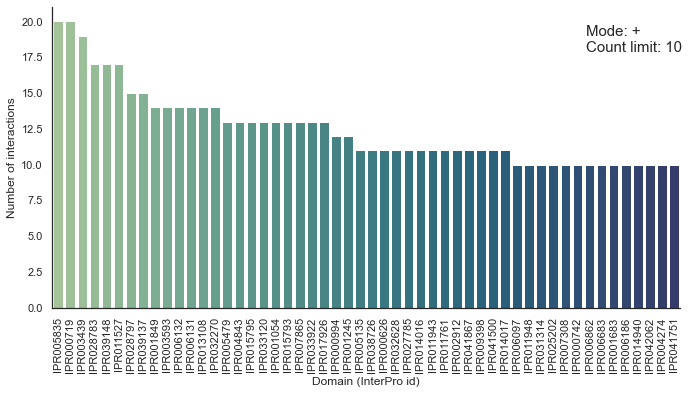

In [145]:
#Plot histogram of number of interactions associated with each domain for activators
plot_histogram_features(type='Domain', aspect=2, mode = '+', count_limit=10)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


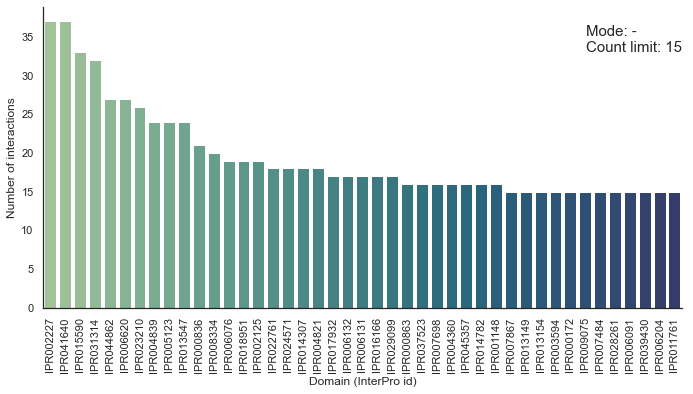

In [147]:
#Plot histogram of number of interactions associated with each domain for inhibitors
plot_histogram_features(type='Domain', aspect=2, mode = '-', count_limit=15)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


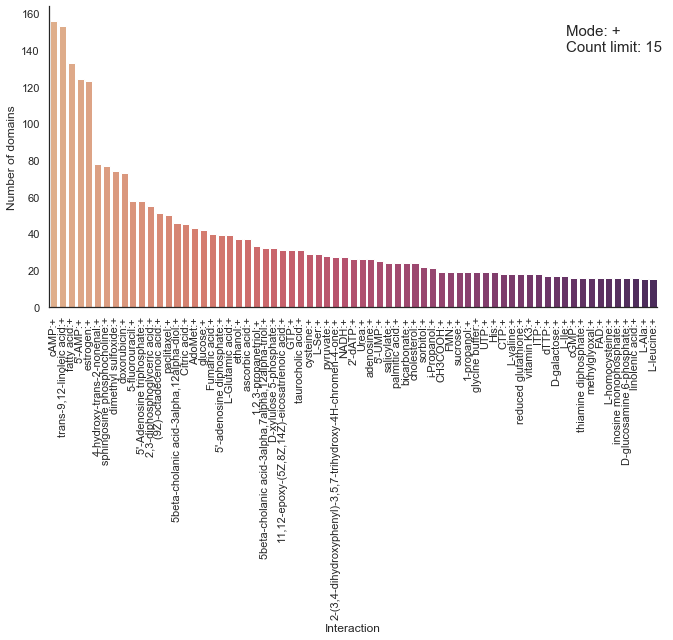

In [151]:
#Plot histogram of number of domains associated with each interaction for activators
plot_histogram_interactions(type='Domain', aspect=2, mode='+', count_limit=15)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


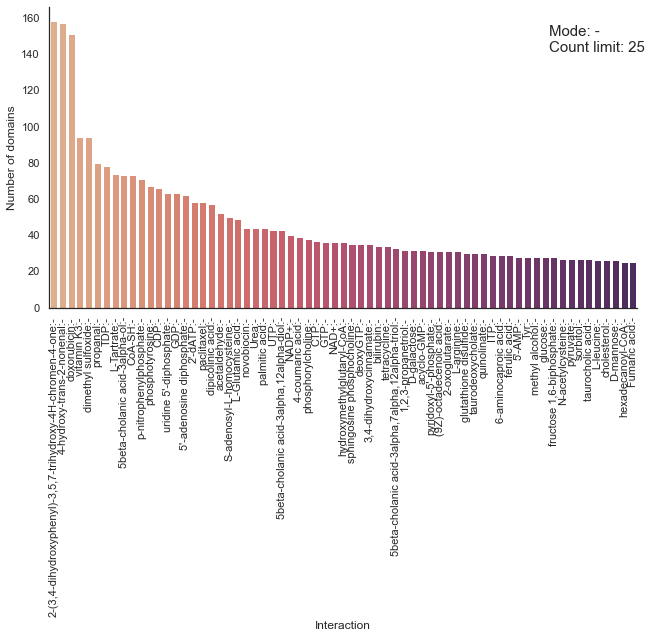

In [157]:
#Plot histogram of number of domains associated with each interaction for inhibitors
plot_histogram_interactions(type='Domain', aspect=2.2, mode='-', count_limit=25)

#### Families

In [18]:
#Look at the most highly associated interactions and families
dfs['Family'].sort_values(['log_q', 'log_o'], ascending=False).head(20)

,Unnamed: 0,interaction,features,odds,p,is_significant,q,log_o,log_q,ENTRY_TYPE,ENTRY_NAME,mode,ChEBI,Met
75,75,CHEBI:17794:+,IPR011831,3917.083333,3.107856e-32,True,5.998991e-28,3.592963,27.221922,Family,Glucose-1-phosphate adenylyltransferase,+,CHEBI:17794,"{D-3-phosphoglyceric acid, D-glyceric acid 3-p..."
46,46,CHEBI:28898:-,IPR000850,699.375000,1.842772e-31,True,2.667781e-27,2.844710,26.573850,Family,Adenylate kinase/UMP-CMP kinase,-,CHEBI:28898,"{P1,P5-(bis adenosine)-5'-pentaphosphate, diad..."
101,101,CHEBI:17969:+,IPR011831,2913.733333,4.052833e-31,True,3.911524e-27,3.464450,26.407654,Family,Glucose-1-phosphate adenylyltransferase,+,CHEBI:17969,"{sedoheptulose-1,7-bisphosphate, sedoheptulose..."
90,90,CHEBI:14336:-,IPR005999,15000.000000,1.997106e-29,True,1.051349e-25,4.176091,24.978253,Family,Glycerol kinase,-,CHEBI:14336,"{alpha-glycerophosphate, DL-glycerol 3-phospha..."
172,172,CHEBI:30841:+,IPR011831,1921.428571,2.345501e-28,True,7.148594e-25,3.283624,24.145779,Family,Glucose-1-phosphate adenylyltransferase,+,CHEBI:30841,"{beta-Hydroxypyruvate, Hydroxypyruvate, 3-hydr..."
184,184,CHEBI:15925:+,IPR011831,1921.428571,2.345501e-28,True,7.148594e-25,3.283624,24.145779,Family,Glucose-1-phosphate adenylyltransferase,+,CHEBI:15925,{2-keto-3-deoxy phosphogluconate}
197,197,CHEBI:55513:+,IPR011831,1921.428571,2.345501e-28,True,7.148594e-25,3.283624,24.145779,Family,Glucose-1-phosphate adenylyltransferase,+,CHEBI:55513,"{deoxyribose 5-phosphate, 2-deoxyribose-5-phos..."
109,109,CHEBI:44897:+,IPR011831,1503.965517,2.751545e-28,True,7.323962e-25,3.177238,24.135254,Family,Glucose-1-phosphate adenylyltransferase,+,CHEBI:44897,"{phosphoenolpyruvate, phospho-enol-pyruvate}"
159,159,CHEBI:30831:+,IPR011831,1793.066667,4.220165e-28,True,9.775252e-25,3.253596,24.009872,Family,Glucose-1-phosphate adenylyltransferase,+,CHEBI:30831,"{alpha-Ketobutyric acid, 2-ketobutanoate, alph..."
175,175,CHEBI:17138:+,IPR011831,1581.647059,1.258806e-27,True,2.429832e-24,3.199110,23.614424,Family,Glucose-1-phosphate adenylyltransferase,+,CHEBI:17138,"{glyceraldehyde-3-phosphate, 3-phosphoglyceral..."


C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


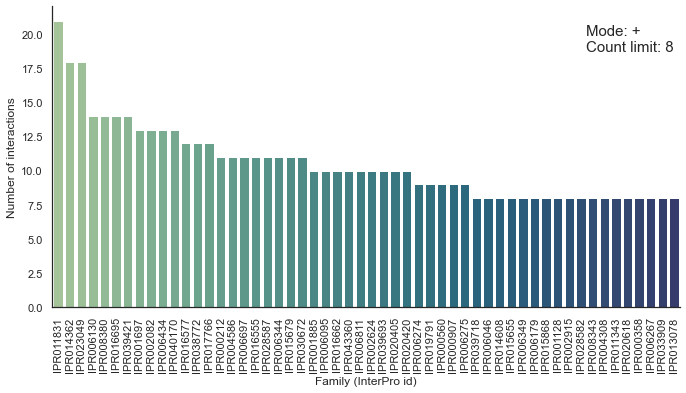

In [162]:
#Plot histogram of number of interactions associated with each family for activators
plot_histogram_features(type='Family', aspect=2, mode='+', count_limit=8)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


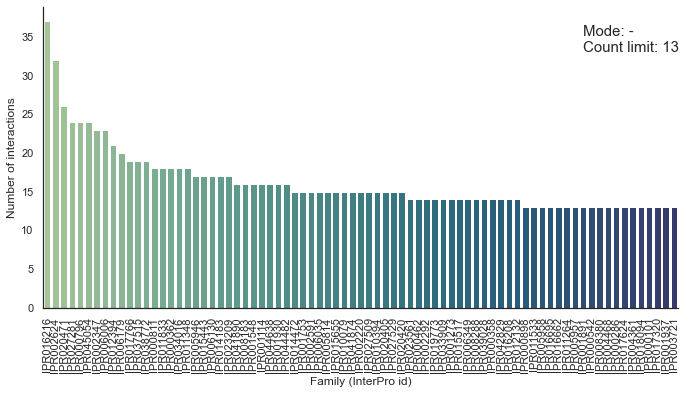

In [168]:
#Plot histogram of number of interactions associated with each family for inhibitors
plot_histogram_features(type='Family', aspect=2, mode='-', count_limit=13)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


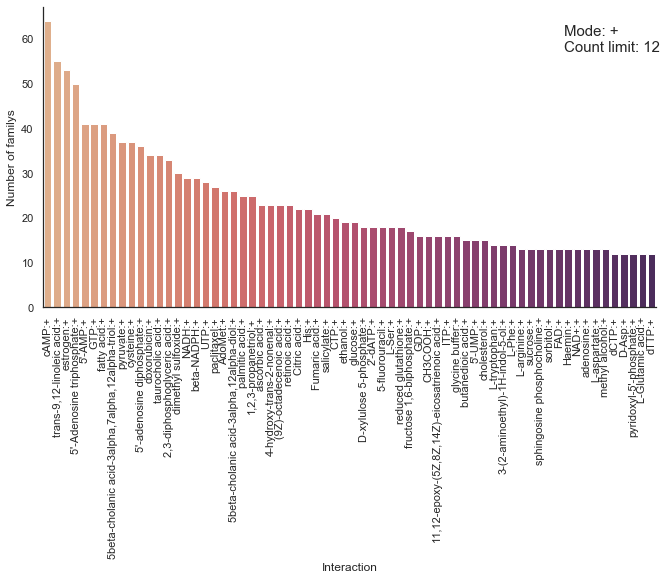

In [173]:
#Plot histogram of number of families associated with each interaction for activators
plot_histogram_interactions(type='Family', aspect=2, mode = '+', count_limit=12)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


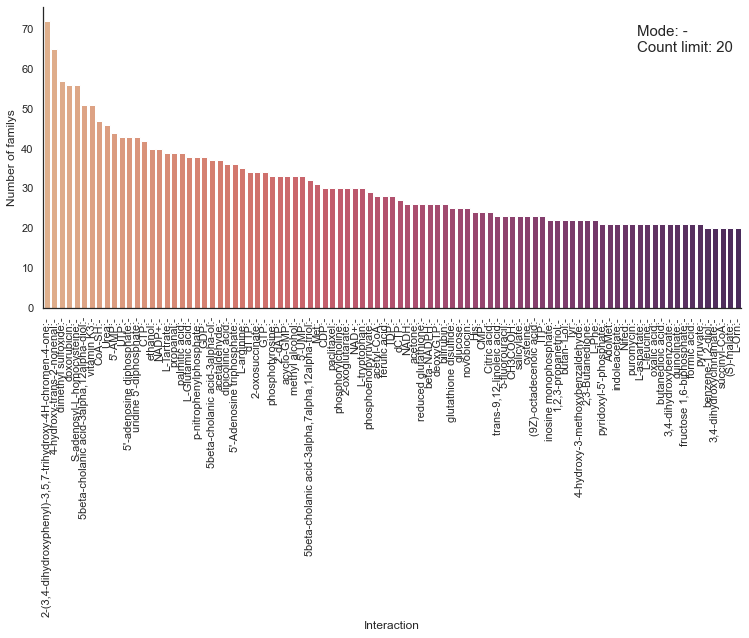

In [174]:
#Plot histogram of number of domains associated with each interaction for inhibitors
plot_histogram_interactions(type='Family', aspect=2.5, mode = '-', count_limit=20)

#### Homologous superfamilies

In [22]:
#Look at the most highly associated interactions and superfamilies
dfs_acts['Homologous_superfamily'].sort_values(['log_q', 'log_o'], ascending=False).head(10)

,Unnamed: 0,interaction,features,odds,p,is_significant,q,log_o,log_q,ENTRY_TYPE,ENTRY_NAME,mode,ChEBI,Met
16,16,CHEBI:17489:+,IPR011009,66.493461,1.301455e-29,True,8.373853e-26,1.822779,25.077075,Homologous_superfamily,Protein kinase-like domain superfamily,+,CHEBI:17489,"{cyclic AMP, cyclic-3',5'-AMP, c-3',5'-AMP, ad..."
74,74,CHEBI:9532:+,IPR029061,469.490000,1.008611e-27,True,2.246409e-24,2.671626,23.648511,Homologous_superfamily,Thiamin diphosphate-binding fold,+,CHEBI:9532,{thiamine diphosphate}
72,72,CHEBI:17794:+,IPR011004,325.888889,1.928982e-26,True,2.864192e-23,2.513070,22.542998,Homologous_superfamily,Trimeric LpxA-like superfamily,+,CHEBI:17794,"{D-3-phosphoglyceric acid, D-glyceric acid 3-p..."
93,93,CHEBI:17969:+,IPR011004,447.533333,3.924079e-26,True,5.680890e-23,2.650825,22.245584,Homologous_superfamily,Trimeric LpxA-like superfamily,+,CHEBI:17969,"{sedoheptulose-1,7-bisphosphate, sedoheptulose..."
166,166,CHEBI:15925:+,IPR011004,411.061224,4.874419e-24,True,4.090839e-21,2.613907,20.388188,Homologous_superfamily,Trimeric LpxA-like superfamily,+,CHEBI:15925,{2-keto-3-deoxy phosphogluconate}
170,170,CHEBI:30841:+,IPR011004,411.061224,4.874419e-24,True,4.090839e-21,2.613907,20.388188,Homologous_superfamily,Trimeric LpxA-like superfamily,+,CHEBI:30841,"{beta-Hydroxypyruvate, Hydroxypyruvate, 3-hydr..."
178,178,CHEBI:55513:+,IPR011004,411.061224,4.874419e-24,True,4.090839e-21,2.613907,20.388188,Homologous_superfamily,Trimeric LpxA-like superfamily,+,CHEBI:55513,"{deoxyribose 5-phosphate, 2-deoxyribose-5-phos..."
160,160,CHEBI:30831:+,IPR011004,383.600000,8.757107e-24,True,6.761421e-21,2.583879,20.169962,Homologous_superfamily,Trimeric LpxA-like superfamily,+,CHEBI:30831,"{alpha-Ketobutyric acid, 2-ketobutanoate, alph..."
177,177,CHEBI:17138:+,IPR011004,338.369748,2.604222e-23,True,1.911698e-20,2.529392,19.718581,Homologous_superfamily,Trimeric LpxA-like superfamily,+,CHEBI:17138,"{glyceraldehyde-3-phosphate, 3-phosphoglyceral..."
113,113,CHEBI:44897:+,IPR011004,231.000000,2.608002e-23,True,1.911698e-20,2.363612,19.718581,Homologous_superfamily,Trimeric LpxA-like superfamily,+,CHEBI:44897,"{phosphoenolpyruvate, phospho-enol-pyruvate}"


C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


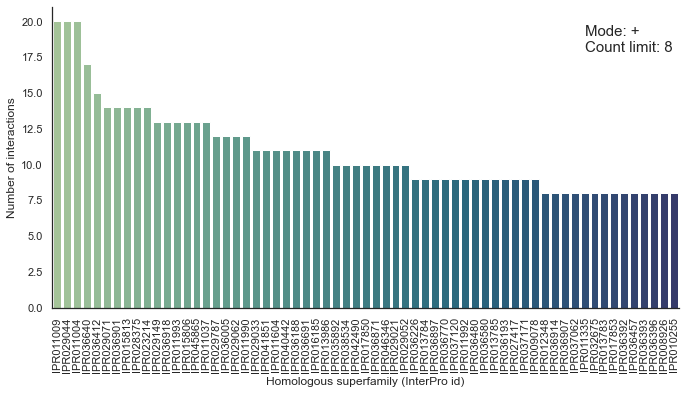

In [179]:
#Plot histogram of number of interactions associated with each homologous superfamily for activators
plot_histogram_features(type='Homologous_superfamily', aspect=2, mode = '+', count_limit=8)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


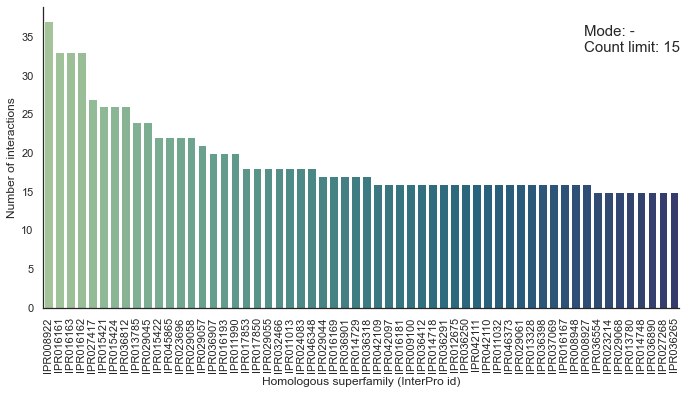

In [185]:
#Plot histogram of number of interactions associated with each homologous superfamily for inhibitors
plot_histogram_features(type='Homologous_superfamily', aspect=2, mode = '-', count_limit=15)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


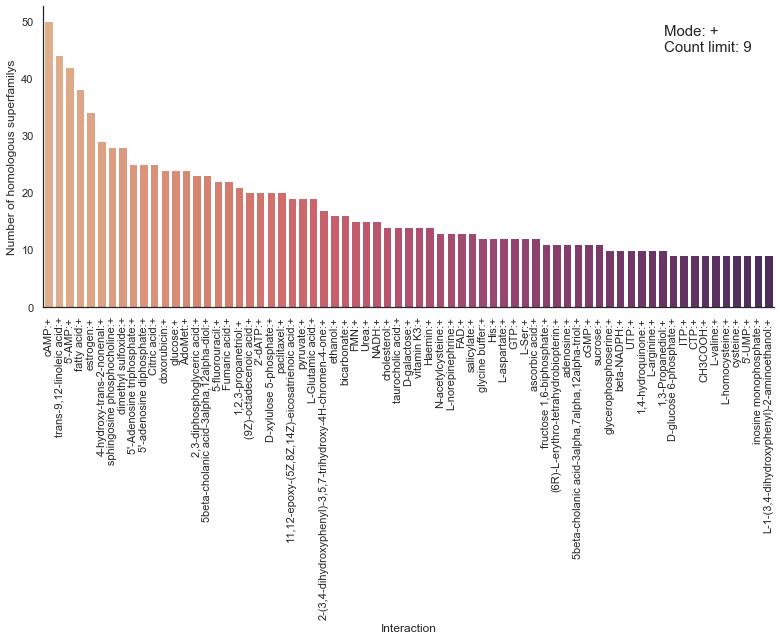

In [190]:
#Plot histogram of number of homologous superfamilies  associated with each interaction for activators
plot_histogram_interactions(type='Homologous_superfamily', aspect=2.5, mode = '+', count_limit=9)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


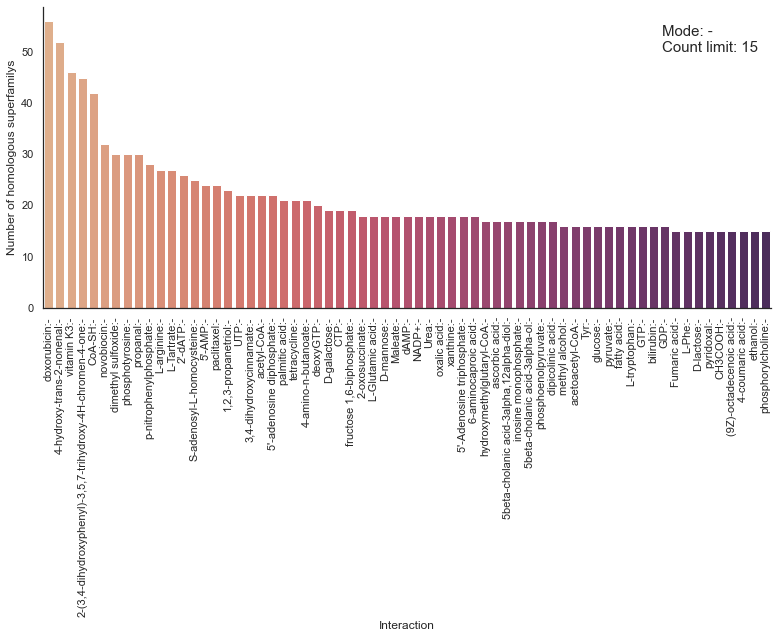

In [194]:
#Plot histogram of number of homologous superfamilies  associated with each interaction for inhibitors
plot_histogram_interactions(type='Homologous_superfamily', aspect=2.5, mode = '-', count_limit=15)

#### PTMs

In [53]:
#Look at the most highly associated interactions and PTMs
dfs['PTM'].sort_values(['log_q', 'log_o'], ascending=False).head(10)

,interaction,features,odds,p,is_significant,q,log_o,log_q,ENTRY_TYPE,ENTRY_NAME,mode,ChEBI,Met
3591,CHEBI:18067:+,IPR000152,1123.333333,4.277744e-08,True,0.000002,3.050509,5.741179,PTM,EGF-type aspartate/asparagine hydroxylation site,+,CHEBI:18067,"{vitamin K, 2-methyl-3-phytyl-1,4-naphthoquino..."
2757,CHEBI:18405:-,IPR006162,115.356522,1.337792e-06,True,0.000034,2.062042,4.469189,PTM,Phosphopantetheine attachment site,-,CHEBI:18405,"{pyridoxal 5'-phosphate, pyridoxal phosphate, ..."
3267,CHEBI:16583:-,IPR018303,34.132653,1.835086e-04,True,0.001877,1.533170,2.726563,PTM,"P-type ATPase, phosphorylation site",-,CHEBI:16583,"{Butanedione, 2,3-Butanedione, diacetyl, Butan..."
8721,CHEBI:16284:-,IPR006141,223.033333,2.472888e-04,True,0.002366,2.348370,2.625956,PTM,Intein N-terminal splicing region,-,CHEBI:16284,"{5'-dATP, deoxyATP, dATP, 2'-deoxy-ATP, 2'-deo..."
56304,CHEBI:17084:-,IPR006141,1687.250000,1.332149e-03,True,0.007747,3.227179,2.110839,PTM,Intein N-terminal splicing region,-,CHEBI:17084,"{alpha-hydroxyglutarate, DL-2-hydroxyglutarate..."
25342,CHEBI:74986:+,IPR000152,15000.000000,1.776725e-03,True,0.009368,4.176091,2.028362,PTM,EGF-type aspartate/asparagine hydroxylation site,+,CHEBI:74986,"{1,2-dioleoyl-sn-glycero-3-phosphoethanolamine}"
16466,CHEBI:27537:-,IPR006162,674.600000,2.663114e-03,True,0.012204,2.829046,1.913503,PTM,Phosphopantetheine attachment site,-,CHEBI:27537,"{octenoyl-CoA, 2,3-trans-octenoyl-CoA, 2-octen..."
20851,CHEBI:28264:-,IPR006162,674.600000,2.663114e-03,True,0.012204,2.829046,1.913503,PTM,Phosphopantetheine attachment site,-,CHEBI:28264,"{3-ketooctanoyl-CoA, 3-oxooctanoyl-CoA}"
24221,CHEBI:62013:+,IPR000152,612.818182,3.550556e-03,True,0.014537,2.787332,1.837521,PTM,EGF-type aspartate/asparagine hydroxylation site,+,CHEBI:62013,"{glycerophosphoserine, L-alpha-glycerophosphor..."
17614,CHEBI:18101:+,IPR018303,481.285714,4.437208e-03,True,0.016701,2.682403,1.777250,PTM,"P-type ATPase, phosphorylation site",+,CHEBI:18101,"{p-hydroxyphenylacetate, (4-hydroxyphenyl)acet..."


C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


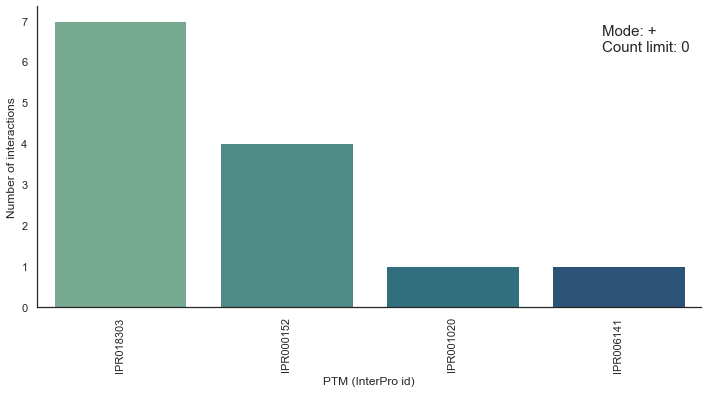

In [196]:
#Plot histogram of number of interactions associated with each PTM for activators
plot_histogram_features(type='PTM', mode = '+', aspect=2)

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


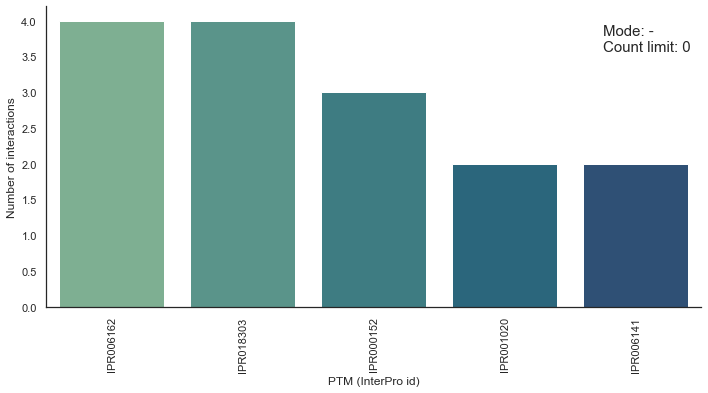

In [197]:
#Plot histogram of number of interactions associated with each PTM for inhibitors
plot_histogram_features(type='PTM', aspect=2, mode='-')

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


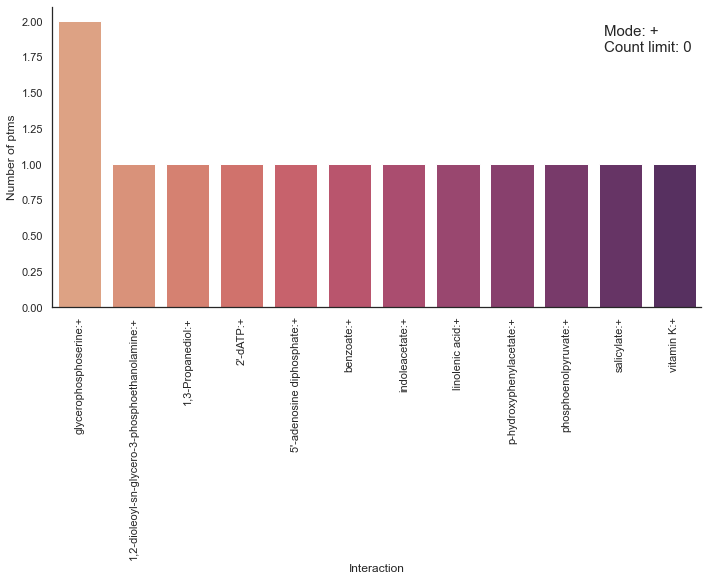

In [199]:
#Plot histogram of number of PTMs associated with each interaction for activators
plot_histogram_interactions(type='PTM', aspect=2, mode='+')

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


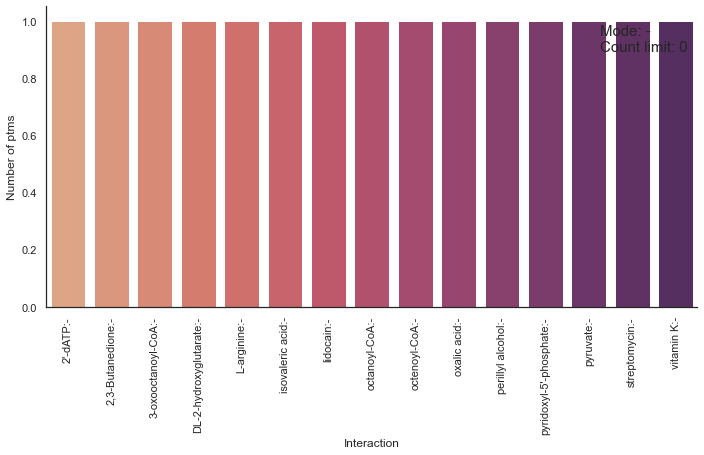

In [198]:
#Plot histogram of number of PTMs associated with each interaction for inhibitors
plot_histogram_interactions(type='PTM', aspect=2, mode='-')

#### Repeats

In [54]:
#Look at the most highly associated interactions and repeats
dfs['Repeat'].sort_values(['log_q', 'log_o'], ascending=False).head(10)

,interaction,features,odds,p,is_significant,q,log_o,log_q,ENTRY_TYPE,ENTRY_NAME,mode,ChEBI,Met
1771,CHEBI:28368:-,IPR006691,1601.666667,3.366175e-12,True,4.554403e-10,3.204572,9.341569,Repeat,"DNA gyrase/topoisomerase IV, subunit A, C-term...",-,CHEBI:28368,"{novobiocin, cathomycin}"
3407,CHEBI:77932:-,IPR006691,561.333333,1.765893e-07,True,6.250569e-06,2.749221,5.204080,Repeat,"DNA gyrase/topoisomerase IV, subunit A, C-term...",-,CHEBI:77932,{tetracycline}
4587,CHEBI:17351:+,IPR019734,96.028571,1.056134e-05,True,1.931732e-04,1.982400,3.714053,Repeat,Tetratricopeptide repeat,+,CHEBI:17351,"{linoleic acid, linolate, (9Z,12Z)-octadecadie..."
4990,CHEBI:16469:+,IPR001611,95.914286,1.246152e-05,True,2.209496e-04,1.981883,3.655707,Repeat,Leucine-rich repeat,+,CHEBI:16469,"{beta-estradiol, 17beta estradiol, 17-beta-est..."
11031,CHEBI:17544:-,IPR013517,15000.000000,1.780321e-05,True,2.979619e-04,4.176091,3.525839,Repeat,FG-GAP repeat,-,CHEBI:17544,"{HCO3-, bicarbonate, hydrogencarbonate, hydrog..."
11033,CHEBI:17544:-,IPR013519,15000.000000,1.780321e-05,True,2.979619e-04,4.176091,3.525839,Repeat,Integrin alpha beta-propellor,-,CHEBI:17544,"{HCO3-, bicarbonate, hydrogencarbonate, hydrog..."
13169,CHEBI:48861:-,IPR001330,898.133333,1.786441e-05,True,2.983825e-04,2.953341,3.525227,Repeat,PFTB repeat,-,CHEBI:48861,"{(E,E,E)-geranylgeranyl diphosphate, geranylge..."
968,CHEBI:15422:+,IPR002110,11.897717,4.558883e-05,True,6.276647e-04,1.075464,3.202272,Repeat,Ankyrin repeat,+,CHEBI:15422,"{ATP, 5'-Adenosine triphosphate, ATP-analogues..."
2104,CHEBI:29073:+,IPR019734,23.248252,6.700415e-05,True,8.535143e-04,1.366390,3.068789,Repeat,Tetratricopeptide repeat,+,CHEBI:29073,"{L-ascorbic acid, D-isoascorbic acid, L-ascorb..."
5783,CHEBI:76451:-,IPR001440,240.607143,7.064556e-05,True,8.910788e-04,2.381309,3.050084,Repeat,Tetratricopeptide repeat 1,-,CHEBI:76451,"{alloxan, Alloxane, 2,4,5,6-tetraoxypyrimidine..."


C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


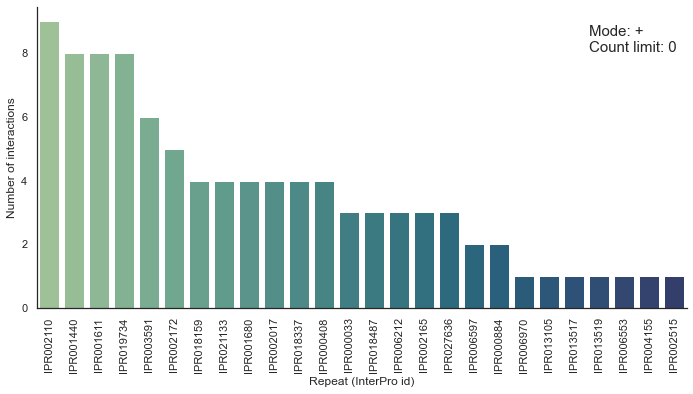

In [201]:
#Plot histogram of number of interactions associated with each repeat for activators
plot_histogram_features(type='Repeat', aspect=2, mode='+')

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\1389530140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


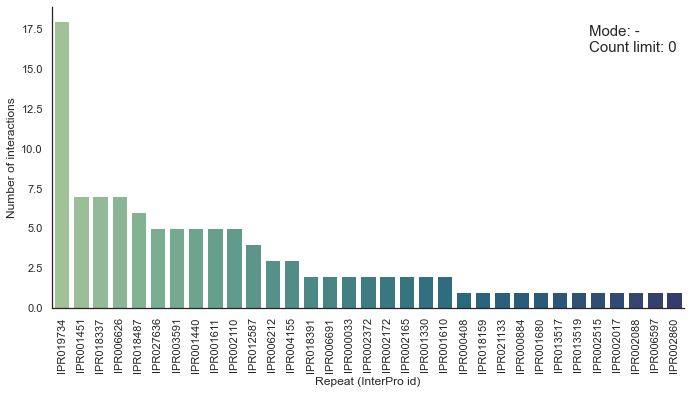

In [200]:
#Plot histogram of number of interactions associated with each repeat for inhibitors
plot_histogram_features(type='Repeat', aspect=2, mode='-')

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


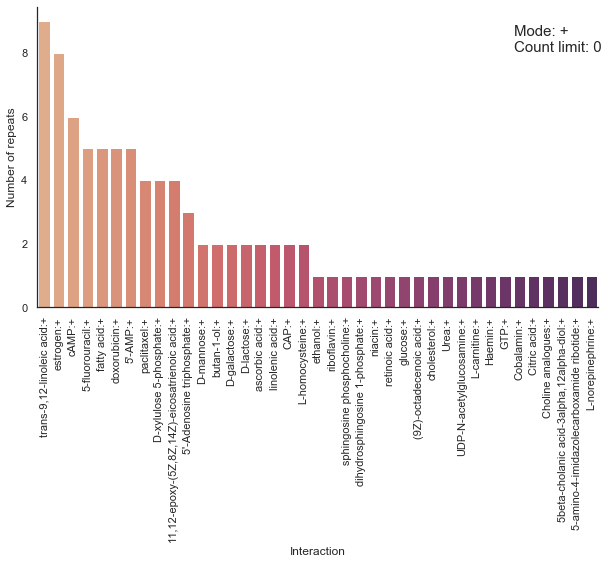

In [202]:
#Plot histogram of number of repeats associated with each interaction for activators
plot_histogram_interactions(type='Repeat', aspect=2, mode='+')

C:\Users\Elin\AppData\Local\Temp\ipykernel_8604\703690530.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_significant['interaction(met)'] = df_significant['Met'].apply(lambda x: list(x)[0]) + ':' + df_significant['mode']


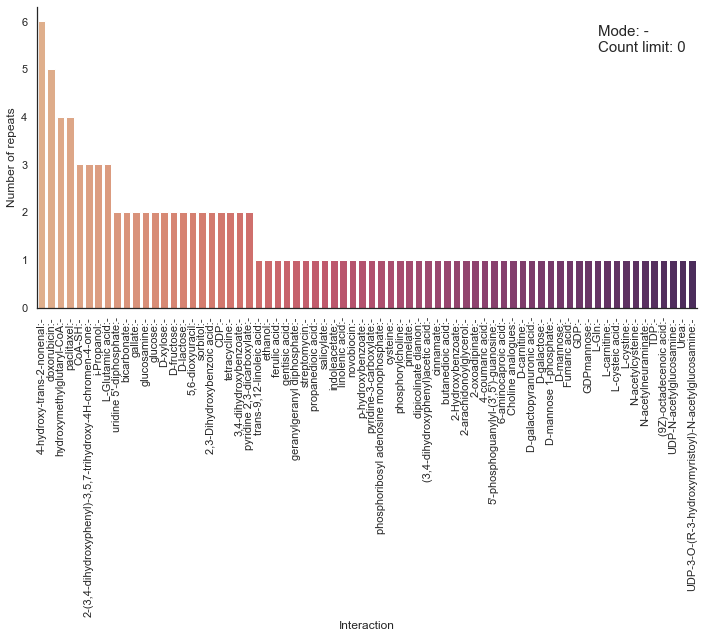

In [204]:
#Plot histogram of number of repeats associated with each interaction for inhibitors
plot_histogram_interactions(type='Repeat', aspect=2.5, mode='-')

#### Volcano plots

(-1.0, 30.0)

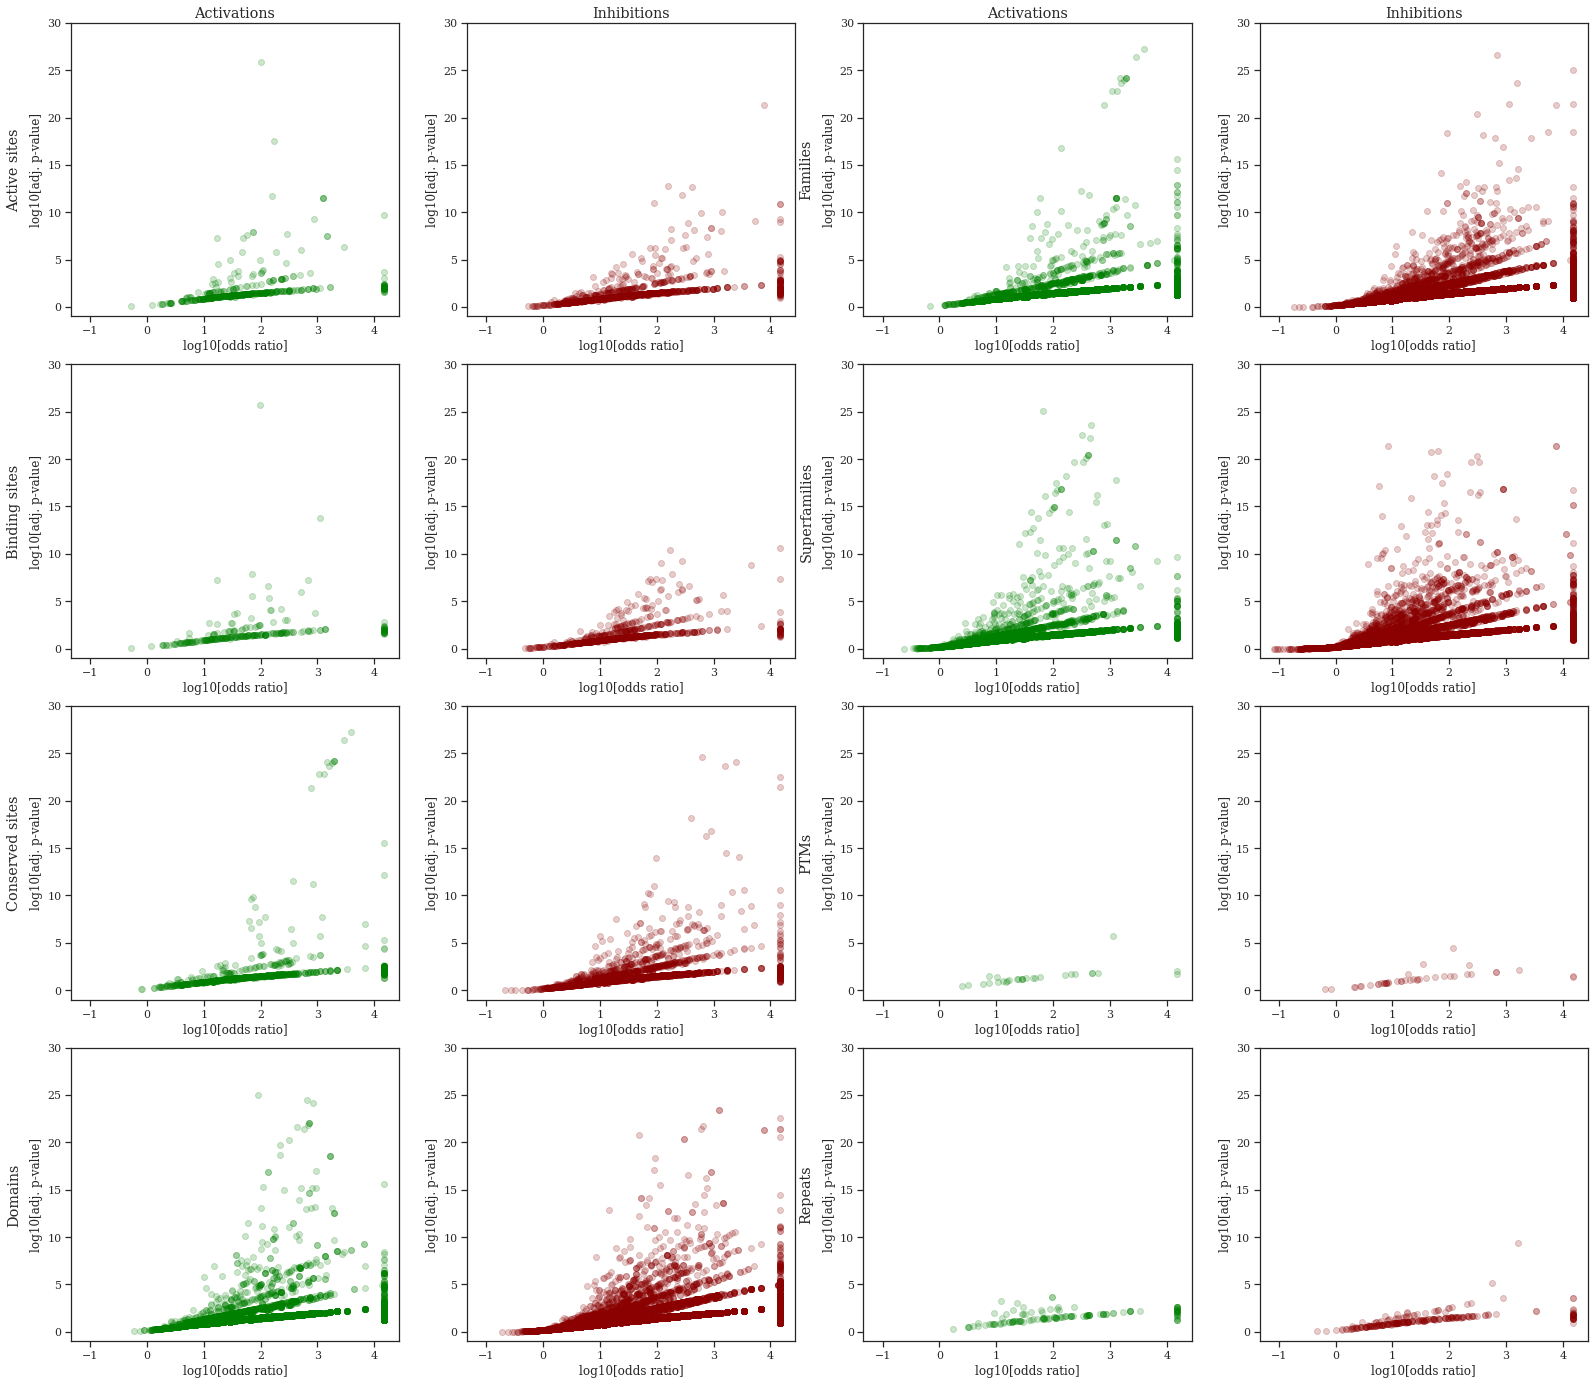

In [48]:
#Create a "superplot" of scatter plots for each feature type to evaluate which feature types has the largest effect
sns.set(style='white')
sns.set_style('ticks')
plt.rcParams["font.family"] = "serif"

cols = ['{}'.format(col) for col in ['Activations', 'Inhibitions', 'Activations', 'Inhibitions']]
rows = ['{}'.format(row) for row in ['Active sites', 'Binding sites', 'Conserved sites', 'Domains', 'Families', 'Superfamilies', 'PTMs', 'Repeats']]

fig, axes = plt.subplots(nrows=4, ncols=4, sharey=True, sharex=True, figsize=(25,20))


pad = 5

#Set x- and y-labels for all plots
plt.setp(axes.flat, xlabel='log10[odds ratio]', ylabel='log10[adj. p-value]')

#Add headers (Activations, Inhibitions)
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

#Add feature type labels
for ax, row in zip(axes[:,0], rows[:4]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)

for ax, row in zip(axes[:,2], rows[4:]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)


#Plot the activating interactions
r, c = 0, 0
for type in dfs_acts:
    axes[r,c].scatter(dfs_acts[type]['log_o'], dfs_acts[type]['log_q'], color='green', alpha=0.2)
    r += 1

    if r == 4:
        r, c = 0, 2

#Plot the inhibiting interactions
r, c = 0, 1
for type in dfs_inhs:
    axes[r,c].scatter(dfs_inhs[type]['log_o'], dfs_inhs[type]['log_q'], color='darkred', alpha=0.2)
    r += 1
    
    if r == 4:
        r, c = 0, 3


for ax in axes.flatten():
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)
plt.ylim(-1,30)

### Plot UpSet plot

In [49]:
import upsetplot as up

In [199]:
df = pd.read_csv('C:/Users/Elin/Documents/GitHub/predicting-allostery/datafiles/results/predicted_interactions.txt', index_col=0)

In [200]:
df = pd.merge(df, df_entry_list, left_on='features', right_on='ENTRY_AC', how='left').drop('ENTRY_AC', axis=1)

In [203]:
#Replace _ with ' ' in feature types, and remove entries not mapped to a type
df['ENTRY_TYPE'] = df['ENTRY_TYPE'].apply(lambda x: x.replace('_', ' '))
df = df.dropna()

In [205]:
#Group the dataframe by interaction to get a list of feature types for every interaction
df_grouped = df.groupby('interaction')['ENTRY_TYPE'].apply(list).reset_index()
df_grouped['ENTRY_TYPE'] = df_grouped['ENTRY_TYPE'].apply(lambda x: ','.join(x))

In [206]:
#Get mode from interaction column and make new dataframes for activators and inhibitors
df_grouped['Mode'] = df_grouped['interaction'].apply(lambda x: x[-1])
df_acts = df_grouped.query('Mode == "+"')
df_inhs = df_grouped.query('Mode == "-"')

In [209]:
#Use UpSet function to create the dataframe of boolean values for making the UpSet plot
features_by_type_acts = up.from_memberships(df_acts.ENTRY_TYPE.str.split(','), data=df_acts)

In [210]:
#Use UpSet function to create the dataframe of boolean values for making the UpSet plot
features_by_type_inhs = up.from_memberships(df_inhs.ENTRY_TYPE.str.split(','), data=df_inhs)

{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: ylabel='Intersection size'>}

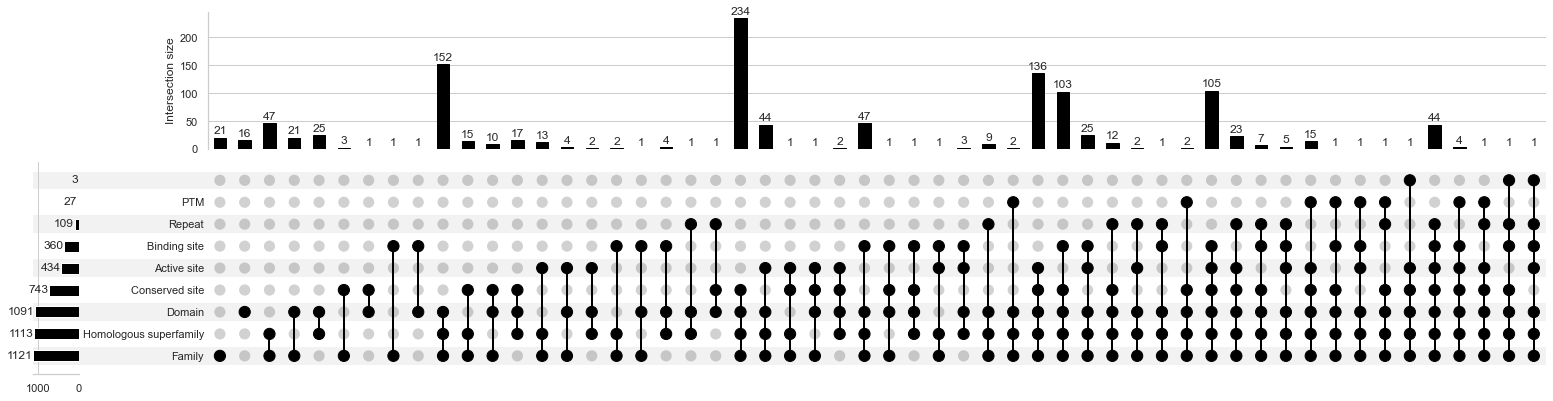

In [211]:
#Plot the UpSet plot
up.UpSet(features_by_type, show_counts=True).plot()

{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: ylabel='Intersection size'>}

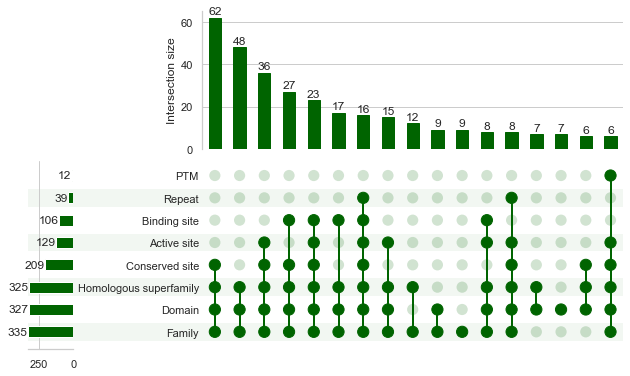

In [222]:
up.UpSet(features_by_type_acts, show_counts=True, sort_by='cardinality', min_subset_size=6, facecolor='darkgreen').plot()

{'matrix': <AxesSubplot: >,
 'shading': <AxesSubplot: >,
 'totals': <AxesSubplot: >,
 'intersections': <AxesSubplot: ylabel='Intersection size'>}

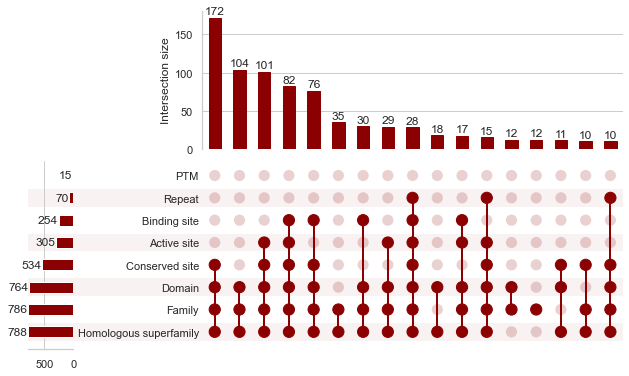

In [225]:
up.UpSet(features_by_type_inhs, show_counts=True, sort_by='cardinality', min_subset_size=10, facecolor='darkred').plot()